In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlp import MLP
import ast
import glob

In [2]:
def load_mlp_model(model_path):
    """Load the trained MLP model"""
    checkpoint = torch.load(model_path, map_location='cpu')
    if 'model' in checkpoint:
        model = checkpoint['model'].cuda()
    else:
        config = checkpoint['config']
        model = MLP(
            input_dim=config['input_dim'],
            hidden_dim=config['hidden_dims'][0],
            output_dim=config['output_dim']
        )#.cuda()
        #model.load_state_dict({k: v.cuda() for k, v in checkpoint['model_state_dict'].items()})
        model.load_state_dict({k: v for k, v in checkpoint['model_state_dict'].items()})
    model.eval()
    return model

def optimize_token_allocation(predictions, token_budget, W=16):
    """
    Optimize token allocation given predictions and budget constraint.
    predictions: list of prediction vectors from MLP
    token_budget: average token limit across all queries
    W: window size (16)
    Returns: list of token allocations for each query
    """
    num_queries = len(predictions)
    max_positions = len(predictions[0])
    
    # Convert predictions to numpy for easier manipulation
    pred_array = np.array(predictions)
    max_budget_per_query = max_positions * W
    
    # Initialize with minimum tokens
    allocations = np.ones(num_queries, dtype=int) * W
    
    # Calculate how many more tokens we can allocate
    remaining_budget = token_budget * num_queries - np.sum(allocations)
    
    while remaining_budget >= W:
        # For each query, calculate potential gain from adding W tokens
        best_gain = -1
        window_increase = 1
        while best_gain < 0:
            gains = []
            for i in range(num_queries):
                current_pos = allocations[i] // W - 1
                if current_pos + window_increase >= max_positions:
                    gains.append(-1)  # Can't allocate more tokens
                else:
                    gains.append(pred_array[i][current_pos + window_increase] - pred_array[i][current_pos])
            
            # Find query with maximum gain
            best_query = np.argmax(gains)
            best_gain = gains[best_query]
            if gains[best_query] <= 0:
                window_increase += 1
            if all([g == -1 for g in gains]):
                break
        #print(f"{remaining_budget} Best gain: {np.round(best_gain, 2)}")
        if best_gain == -1:
            print("No more gains, breaking")
            break
            
        # Allocate W more tokens to the best query
        allocations[best_query] += W
        remaining_budget -= W
    
    # Distribute remaining tokens
    i = 0
    while remaining_budget >= W:
        if all([a >= max_budget_per_query for a in allocations]):
            break
        if allocations[i % (num_queries)] + W <= max_budget_per_query:
            allocations[i % (num_queries)] += W
            remaining_budget -= W
        i += 1
        
    return allocations.tolist()

def load_gsm8k_data():
    """Load GSM8K data from CSV files"""
    # Load all Y data files
    all_data = []
    for split in ['train', 'test']:
        y_files = list(sorted(glob.glob(f"data/gsm8k_results/gsm8k_Y_{split}_*.csv")))
        x_files = list(sorted(glob.glob(f"data/gsm8k_results/gsm8k_X_{split}_*.csv")))
        print(split,len(x_files),len(y_files))
        
        for x_file, y_file in zip(x_files, y_files):
            df = pd.read_csv(y_file)
            df_x = pd.read_csv(x_file)[['question_id', 'hidden_state']]
            df = df.merge(df_x, on="question_id", how="left")
            df['early_stop_correct_proportions'] = df['early_stop_correct_proportions'].apply(ast.literal_eval)
            df['split'] = split
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)



In [3]:
# Load GSM8K data
print("Loading GSM8K data...")
df = load_gsm8k_data()
df["split"].value_counts()

Loading GSM8K data...
train 75 75
test 14 14


split
train    7450
test     1294
Name: count, dtype: int64

In [4]:
# Load the MLP model
model = load_mlp_model('models/mlp_gsm8k_train_layer_16_arch_256_act_relu_drop_0.00.pt')

    
# Get predictions from MLP
print("Getting predictions from MLP...")
with torch.no_grad():
        hidden_states = torch.tensor(np.vstack(df['hidden_state'].apply(ast.literal_eval).values), 
                                   dtype=torch.float32)#.cuda()
        predictions = model(hidden_states).cpu().numpy()
    
print("Optimizing token allocation...")
# Create DataFrame for results
budgets = range(16, 257, 16)  # Token budgets from 16 to 256 in steps of 16


Input dim: 1536, Hidden dim: 256, Output dim: 16
Getting predictions from MLP...
Optimizing token allocation...


In [5]:
df["split"].value_counts()

split
train    7450
test     1294
Name: count, dtype: int64

In [6]:
from collections import Counter
results = []
for budget in budgets:
        print(f"Budget: {budget}")
        # Get optimized token allocations
        allocations = []
        allocations_oracle = []
        batch_size = 64
        for i in range(0, len(predictions), batch_size):
            batch_predictions = predictions[i:i+batch_size]
            batch_allocations = optimize_token_allocation(batch_predictions, budget)
            allocations.extend(batch_allocations)
            batch_actual = df['early_stop_correct_proportions'].values[i:i+batch_size]
            batch_allocations_oracle = optimize_token_allocation(batch_actual, budget)
            allocations_oracle.extend(batch_allocations_oracle)
        print(Counter(allocations))
        
        # Calculate accuracies
        for i, (pred, actual) in enumerate(zip(predictions, df['early_stop_correct_proportions'].values)):
            # Adaptive accuracy using MLP predictions
            window_idx = allocations[i] // 16 - 1
            adaptive_accuracy = actual[window_idx]
            
            # Nonadaptive accuracy (equal allocation)
            nonadaptive_window_idx = budget // 16 - 1
            nonadaptive_accuracy = actual[nonadaptive_window_idx]
            
            # Oracle accuracy
            oracle_window_idx = allocations_oracle[i] // 16 - 1
            oracle_accuracy = actual[oracle_window_idx]
            split = df['split'].iloc[i]
            
            results.append({
                'question_id': df['question_id'].iloc[i],  # Add question ID if available
                'budget': budget,
                'allocation': allocations[i],
                'accuracy_adaptive_model': adaptive_accuracy,
                'accuracy_nonadaptive': nonadaptive_accuracy,
                'accuracy_oracle': oracle_accuracy,
                'split': split
            })
            
        # Print summary statistics for this budget
        current_results = [r for r in results if r['budget'] == budget]
        print(f"Budget: {budget}")
        print(f"Adaptive Accuracy: {np.mean([r['accuracy_adaptive_model'] for r in current_results])}")
        print(f"Nonadaptive Accuracy: {np.mean([r['accuracy_nonadaptive'] for r in current_results])}")
        print(f"Oracle Accuracy: {np.mean([r['accuracy_oracle'] for r in current_results])}")

Budget: 16
Counter({16: 8744})
Budget: 16
Adaptive Accuracy: 0.12011207685269899
Nonadaptive Accuracy: 0.12011207685269899
Oracle Accuracy: 0.12011207685269899
Budget: 32
Counter({16: 7379, 144: 666, 48: 292, 176: 173, 32: 82, 160: 32, 64: 29, 96: 27, 80: 23, 112: 12, 256: 12, 128: 9, 240: 3, 208: 2, 224: 2, 192: 1})
Budget: 32
Adaptive Accuracy: 0.15863334858188471
Nonadaptive Accuracy: 0.11820105215004574
Oracle Accuracy: 0.20383348581884722
Budget: 48
Counter({16: 6354, 144: 838, 176: 641, 48: 426, 32: 187, 256: 160, 64: 30, 96: 26, 160: 24, 208: 13, 80: 13, 128: 10, 224: 9, 112: 9, 192: 2, 240: 2})
Budget: 48
Adaptive Accuracy: 0.19195905763952426
Nonadaptive Accuracy: 0.1365816559926807
Oracle Accuracy: 0.24214661482159194
Budget: 64
Counter({16: 5503, 176: 1006, 144: 841, 48: 500, 256: 462, 32: 264, 160: 46, 64: 27, 96: 21, 208: 17, 112: 15, 128: 14, 80: 11, 224: 6, 192: 6, 240: 5})
Budget: 64
Adaptive Accuracy: 0.22118709972552608
Nonadaptive Accuracy: 0.17672346752058554
Oracle

In [7]:
print("Creating ResultsDataFrame...")
# Create DataFrame
df_res = pd.DataFrame(results)
df_res.columns

Creating ResultsDataFrame...


Index(['question_id', 'budget', 'allocation', 'accuracy_adaptive_model',
       'accuracy_nonadaptive', 'accuracy_oracle', 'split'],
      dtype='object')

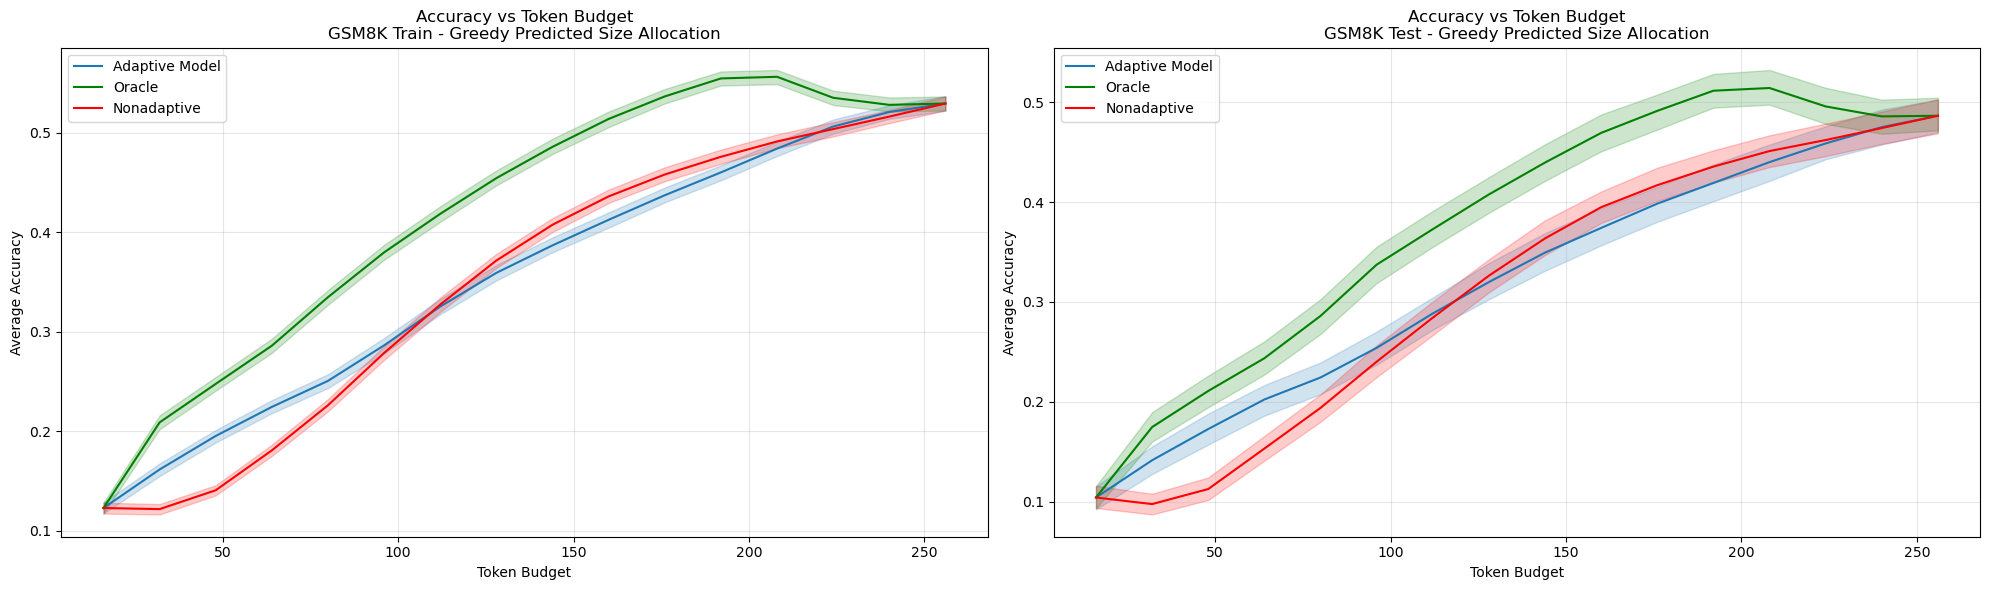

In [9]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Train plot
sns.lineplot(data=df_res.loc[df_res['split'] == 'train'], x="budget", y="accuracy_adaptive_model", label='Adaptive Model', ax=ax1)
sns.lineplot(data=df_res.loc[df_res['split'] == 'train'], x="budget", y="accuracy_oracle", label='Oracle', color='green', ax=ax1)
sns.lineplot(data=df_res.loc[df_res['split'] == 'train'], x="budget", y="accuracy_nonadaptive", label='Nonadaptive', color='red', ax=ax1)
ax1.set_title('Accuracy vs Token Budget\nGSM8K Train - Greedy Predicted Size Allocation')
ax1.set_xlabel('Token Budget')
ax1.set_ylabel('Average Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Test plot
sns.lineplot(data=df_res.loc[df_res['split'] == 'test'], x="budget", y="accuracy_adaptive_model", label='Adaptive Model', ax=ax2)
sns.lineplot(data=df_res.loc[df_res['split'] == 'test'], x="budget", y="accuracy_oracle", label='Oracle', color='green', ax=ax2)
sns.lineplot(data=df_res.loc[df_res['split'] == 'test'], x="budget", y="accuracy_nonadaptive", label='Nonadaptive', color='red', ax=ax2)
ax2.set_title('Accuracy vs Token Budget\nGSM8K Test - Greedy Predicted Size Allocation')
ax2.set_xlabel('Token Budget')
ax2.set_ylabel('Average Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [10]:
df_res.to_csv("data/plot_size.csv")

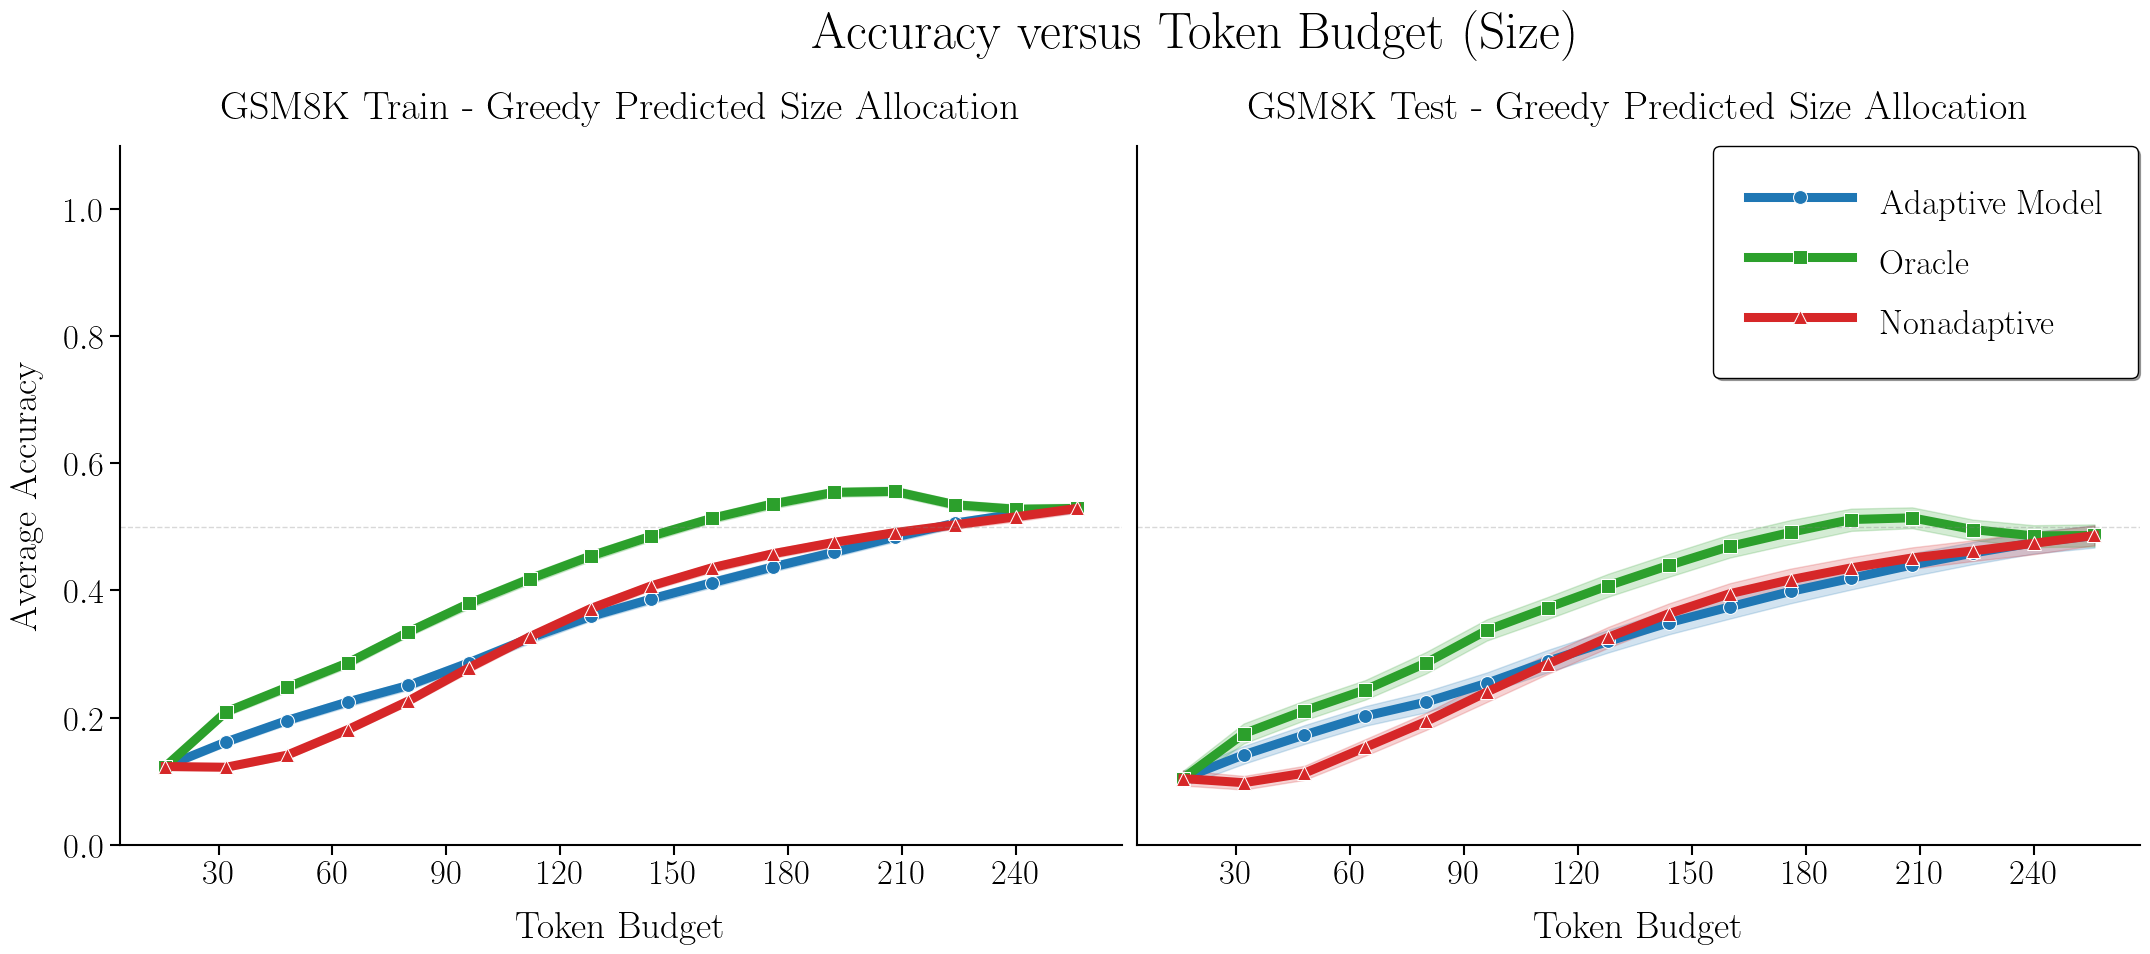

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from matplotlib.ticker import MaxNLocator

# Set the path to your LaTeX executable if needed
if os.path.exists("/Library/TeX/texbin/latex"):
    latex_path = "/Library/TeX/texbin/latex"
    latex_dir = os.path.dirname(latex_path)
    os.environ['PATH'] = os.environ['PATH'] + os.pathsep + latex_dir

# Font size controls - easily adjustable
PLUS = 7  # Increase this value to make all text larger
TITLE_SIZE = 26 + PLUS
SUBTITLE_SIZE = 22 + PLUS
LABEL_SIZE = 20 + PLUS
TICK_SIZE = 18 + PLUS
TEXT_SIZE = 18 + PLUS
LEGEND_SIZE = 18 + PLUS
EQUATION_SIZE = 18 + PLUS
NOTE_SIZE = 18 + PLUS

# Line styling parameters
LINE_WIDTH = 6.5  # Thicker lines
MARKER_SIZE = 10  # Larger markers

# Colors - using a more professional color palette
COLORS = {
    'adaptive': '#1f77b4',  # Blue
    'oracle': '#2ca02c',    # Green
    'nonadaptive': '#d62728'  # Red
}

# Configure matplotlib with LaTeX rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": LABEL_SIZE,
    "axes.titlesize": SUBTITLE_SIZE,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
    "figure.titlesize": TITLE_SIZE,
    "text.latex.preamble": r'\usepackage{amsmath} \usepackage{amssymb}',
    "axes.linewidth": 1.5,  # Thicker axis lines
    "xtick.major.width": 1.5,  # Thicker tick marks
    "ytick.major.width": 1.5,
    "xtick.major.size": 7,  # Longer tick marks
    "ytick.major.size": 7,
    "axes.spines.top": False,    # Remove top spine for cleaner look
    "axes.spines.right": False,  # Remove right spine for cleaner look
})

# Create a figure with two subplots side by side with more space
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Function to style each axis consistently
def style_axis(ax, title, split_name, show_ylabel=True):
    # Plot data with improved styling
    sns.lineplot(
        data=df_res.loc[df_res['split'] == split_name], 
        x="budget", 
        y="accuracy_adaptive_model", 
        label='Adaptive Model', 
        ax=ax,
        color=COLORS['adaptive'],
        linewidth=LINE_WIDTH,
        marker='o',
        markersize=MARKER_SIZE
    )
    
    sns.lineplot(
        data=df_res.loc[df_res['split'] == split_name], 
        x="budget", 
        y="accuracy_oracle", 
        label='Oracle', 
        ax=ax,
        color=COLORS['oracle'],
        linewidth=LINE_WIDTH,
        marker='s',  # Square marker for distinction
        markersize=MARKER_SIZE
    )
    
    sns.lineplot(
        data=df_res.loc[df_res['split'] == split_name], 
        x="budget", 
        y="accuracy_nonadaptive", 
        label='Nonadaptive', 
        ax=ax,
        color=COLORS['nonadaptive'],
        linewidth=LINE_WIDTH,
        marker='^',  # Triangle marker for distinction
        markersize=MARKER_SIZE
    )
    
    # Set titles and labels
    ax.set_title(title, pad=20)  # Add padding for title
    ax.set_xlabel('Token Budget', labelpad=15)  # Add padding for xlabel
    
    if show_ylabel:
        ax.set_ylabel('Average Accuracy', labelpad=15)  # Add padding for ylabel
    else:
        ax.set_ylabel('')  # Remove y-label for right subplot
    
    # Turn off grid as requested
    ax.grid(False)
    
    # Improve y-axis range (start from slightly below min value, go slightly above max)
    y_data = [
        df_res.loc[df_res['split'] == split_name, 'accuracy_adaptive_model'],
        df_res.loc[df_res['split'] == split_name, 'accuracy_oracle'],
        df_res.loc[df_res['split'] == split_name, 'accuracy_nonadaptive']
    ]
    y_min = min([d.min() for d in y_data if not d.empty])
    y_max = max([d.max() for d in y_data if not d.empty])
    y_padding = (y_max - y_min) * 0.1  # 10% padding
    ax.set_ylim(max(0, y_min - y_padding), y_max + y_padding)
    
    # Force integer x-ticks
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Make background slightly off-white for better contrast
    #ax.set_facecolor('#f8f9fa')
    
    # Add a thin horizontal grid line at y=0.5 as a reference
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3, linewidth=1)

# Style both subplots - only show y-label on left subplot
style_axis(ax1, r'GSM8K Train - Greedy Predicted Size Allocation', 'train', show_ylabel=True)
style_axis(ax2, r'GSM8K Test - Greedy Predicted Size Allocation', 'test', show_ylabel=False)

# Remove legend from the left subplot (no need to call it in style_axis function)
ax1.get_legend().remove()

# Remove y-axis labels and ticks from right subplot
ax2.tick_params(axis='y', which='both', left=False, labelleft=False)

# Add a super title
fig.suptitle(r'Accuracy versus Token Budget (Size)', fontsize=TITLE_SIZE + 4, y=0.95)

# Create a single legend outside of the plots
handles, labels = ax2.get_legend_handles_labels()
ax2.get_legend().remove()  # Remove the legend from the second subplot

# Add the legend to the figure (outside the plots)
legend = fig.legend(
    handles, 
    labels,
    bbox_to_anchor=(0.9, 0.83),
    frameon=True,
    fancybox=True,
    framealpha=1,
    shadow=True,
    borderpad=1,
    handlelength=3,
    handleheight=1.5,
    fontsize=LEGEND_SIZE
)
legend.get_frame().set_edgecolor('black')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust rect to make room for the legend and super title
plt.savefig("figures/cs2241_size_accuracy.pdf", bbox_inches='tight', dpi=300)
plt.show()

# Overlay size and difficulty predictions

In [32]:
df_difficulty = pd.read_csv("data/plot_difficulty.csv")
df_size = pd.read_csv("data/plot_size.csv")

# Merge the two dataframes on question_id
df_merged = pd.merge(df_difficulty[["question_id", "accuracy_difficulty_pred_model", "budget"]], df_size, on=['question_id','budget'], how='left')

# Create a figure with two subplots side by side
print(df_merged.shape, df_difficulty.shape, df_size.shape)
print(df_merged.columns)


(139904, 9) (139904, 15) (139904, 8)
Index(['question_id', 'accuracy_difficulty_pred_model', 'budget', 'Unnamed: 0',
       'allocation', 'accuracy_adaptive_model', 'accuracy_nonadaptive',
       'accuracy_oracle', 'split'],
      dtype='object')


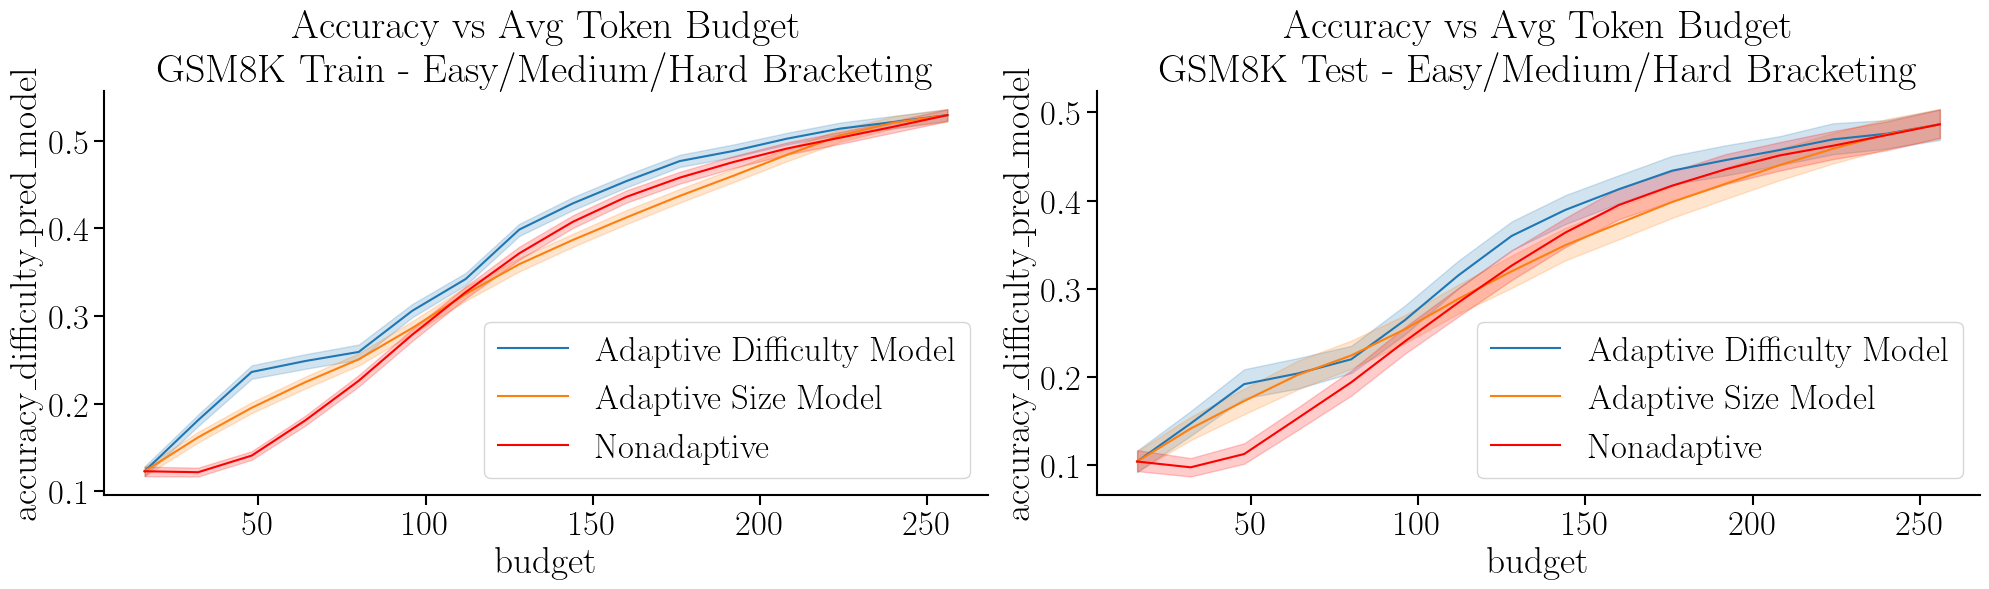

In [33]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Train plot
#sns.lineplot(data=df_merged.query("split == 'train'"), x="budget", y="accuracy_difficulty_pred_zeroshot", label='Adaptive Zeroshot', ax=ax1)
sns.lineplot(data=df_merged.query("split == 'train'"), x="budget", y="accuracy_difficulty_pred_model", label='Adaptive Difficulty Model', ax=ax1)
sns.lineplot(data=df_merged.query("split == 'train'"), x="budget", y="accuracy_adaptive_model", label='Adaptive Size Model', ax=ax1)
sns.lineplot(data=df_merged.query("split == 'train'"), x="budget", y="accuracy_nonadaptive", label='Nonadaptive', ax=ax1, color='red')
ax1.set_title('Accuracy vs Avg Token Budget\nGSM8K Train - Easy/Medium/Hard Bracketing')
ax1.legend()

# Test plot
sns.lineplot(data=df_merged.query("split == 'test'"), x="budget", y="accuracy_difficulty_pred_model", label='Adaptive Difficulty Model', ax=ax2)
sns.lineplot(data=df_merged.query("split == 'test'"), x="budget", y="accuracy_adaptive_model", label='Adaptive Size Model', ax=ax2)
sns.lineplot(data=df_merged.query("split == 'test'"), x="budget", y="accuracy_nonadaptive", label='Nonadaptive', ax=ax2, color='red')
ax2.set_title('Accuracy vs Avg Token Budget\nGSM8K Test - Easy/Medium/Hard Bracketing')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

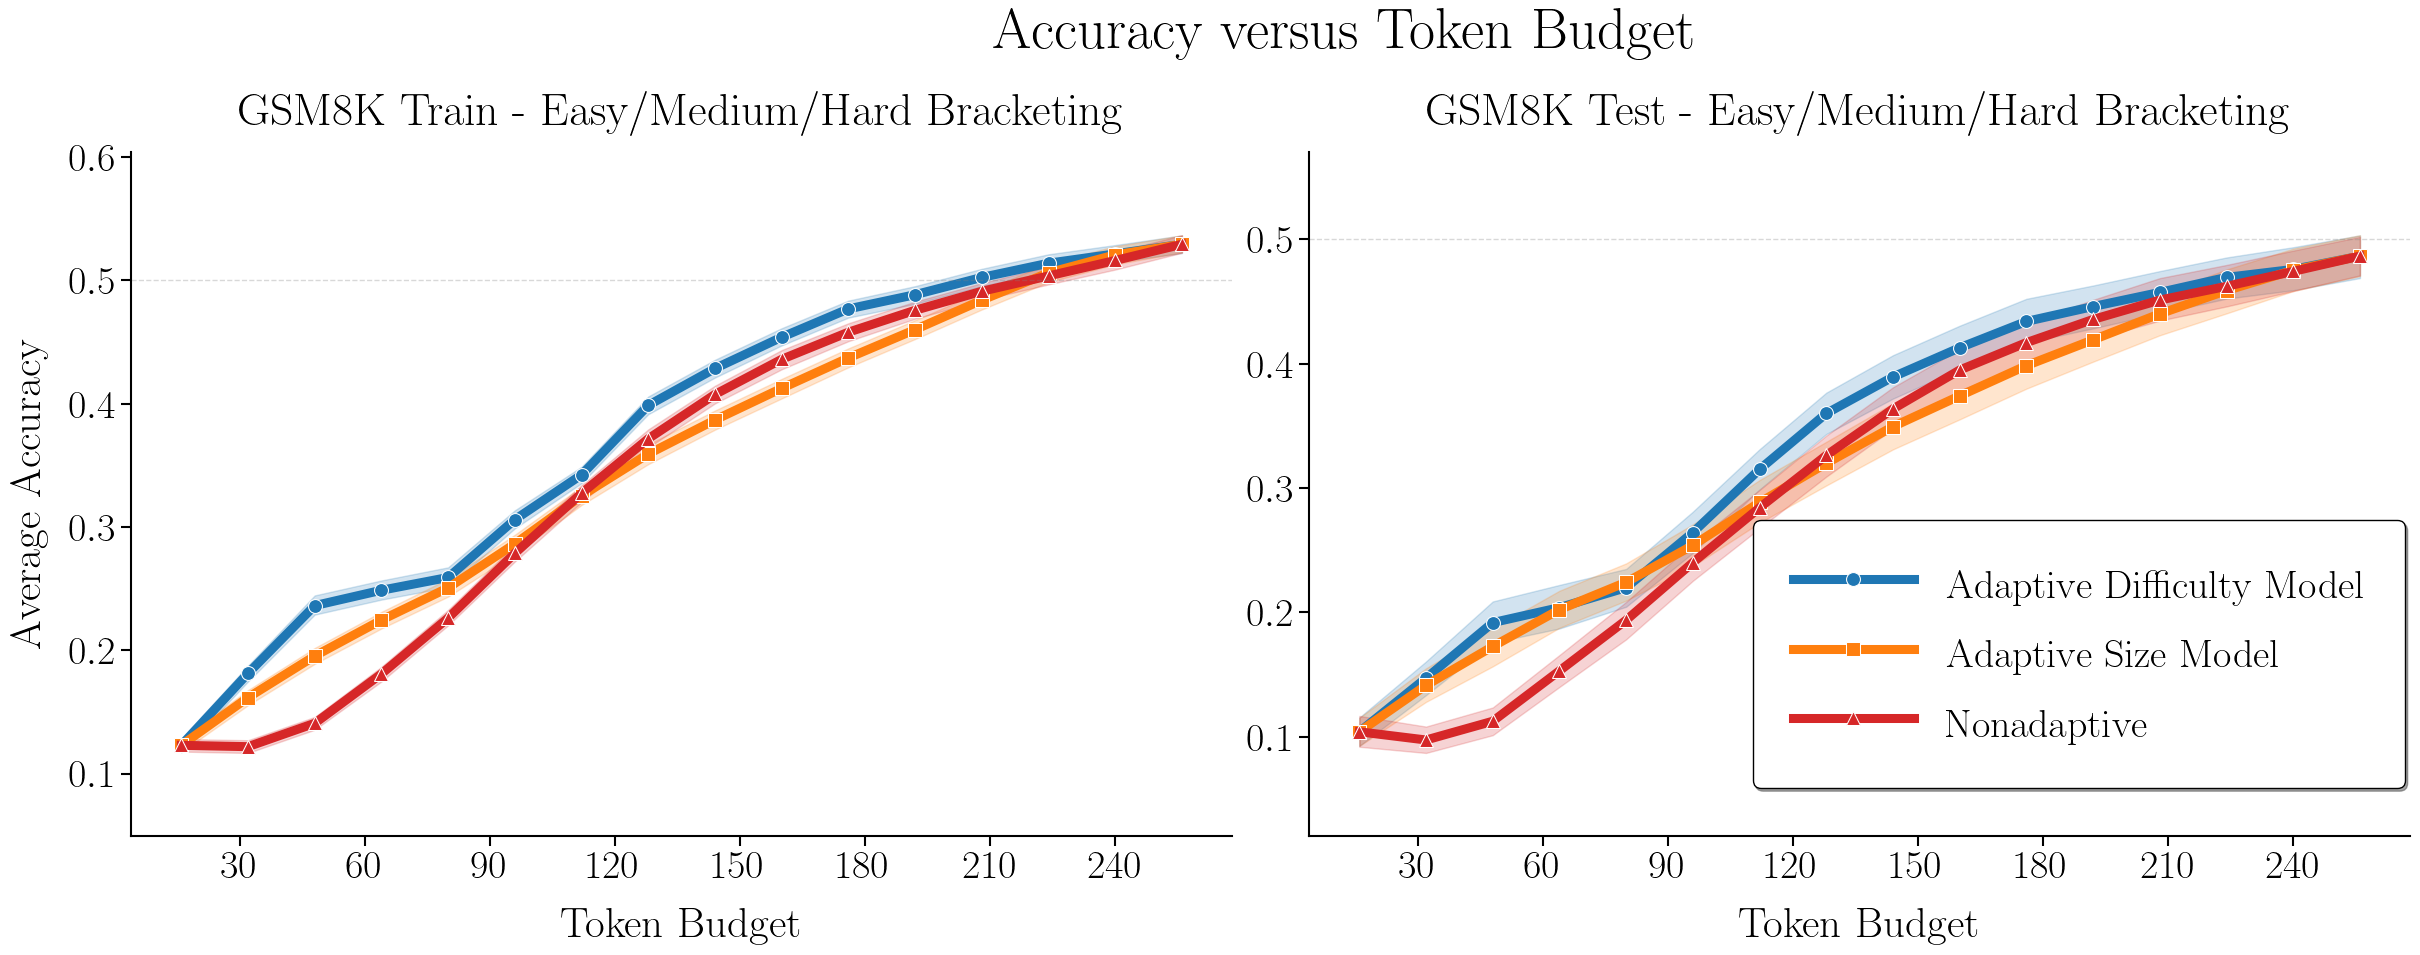

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from matplotlib.ticker import MaxNLocator

# Check for LaTeX and configure path if available
if os.path.exists("/Library/TeX/texbin/latex"):
    latex_path = "/Library/TeX/texbin/latex"
    latex_dir = os.path.dirname(latex_path)
    os.environ['PATH'] = os.environ['PATH'] + os.pathsep + latex_dir

# Create figures directory if it doesn't exist
os.makedirs('figures', exist_ok=True)

# Font size controls - easily adjustable
PLUS = 11  # Increase this value to make all text larger
TITLE_SIZE = 26 + PLUS
SUBTITLE_SIZE = 22 + PLUS
LABEL_SIZE = 20 + PLUS
TICK_SIZE = 18 + PLUS
TEXT_SIZE = 18 + PLUS
LEGEND_SIZE = 18 + PLUS
EQUATION_SIZE = 18 + PLUS
NOTE_SIZE = 18 + PLUS

# Line styling parameters
LINE_WIDTH = 6.5  # Thicker lines
MARKER_SIZE = 10  # Larger markers

# Colors - using the original seaborn color palette but with increased visibility
COLORS = {
    'adaptive_difficulty': '#1f77b4',  # Default seaborn blue
    'adaptive_size': '#ff7f0e',       # Default seaborn orange
    'nonadaptive': '#d62728'          # Red (as specified in original code)
}

# Configure matplotlib with LaTeX rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": LABEL_SIZE,
    "axes.titlesize": SUBTITLE_SIZE,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
    "figure.titlesize": TITLE_SIZE,
    "text.latex.preamble": r'\usepackage{amsmath} \usepackage{amssymb}',
    "axes.linewidth": 1.5,  # Thicker axis lines
    "xtick.major.width": 1.5,  # Thicker tick marks
    "ytick.major.width": 1.5,
    "xtick.major.size": 7,  # Longer tick marks
    "ytick.major.size": 7,
    "axes.spines.top": False,  # Remove top spine for cleaner look
    "axes.spines.right": False,  # Remove right spine for cleaner look
})

# Create a figure with two subplots side by side with more space
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(27, 10))

# Function to style each axis consistently
def style_axis(ax, title, split_name, show_ylabel=True):
    # Train data
    if split_name == 'train':
        # Plot with appropriate styling
        sns.lineplot(
            data=df_merged.query("split == 'train'"), 
            x="budget", 
            y="accuracy_difficulty_pred_model", 
            label='Adaptive Difficulty Model',
            ax=ax,
            color=COLORS['adaptive_difficulty'],
            linewidth=LINE_WIDTH,
            marker='o',
            markersize=MARKER_SIZE
        )
        
        sns.lineplot(
            data=df_merged.query("split == 'train'"), 
            x="budget", 
            y="accuracy_adaptive_model", 
            label='Adaptive Size Model',
            ax=ax,
            color=COLORS['adaptive_size'],
            linewidth=LINE_WIDTH,
            marker='s',  # Square marker for distinction
            markersize=MARKER_SIZE
        )
        
        sns.lineplot(
            data=df_merged.query("split == 'train'"), 
            x="budget", 
            y="accuracy_nonadaptive", 
            label='Nonadaptive',
            ax=ax,
            color=COLORS['nonadaptive'],
            linewidth=LINE_WIDTH,
            marker='^',  # Triangle marker for distinction
            markersize=MARKER_SIZE
        )
    # Test data
    else:
        # Plot with appropriate styling
        sns.lineplot(
            data=df_merged.query("split == 'test'"), 
            x="budget", 
            y="accuracy_difficulty_pred_model", 
            label='Adaptive Difficulty Model',
            ax=ax,
            color=COLORS['adaptive_difficulty'],
            linewidth=LINE_WIDTH,
            marker='o',
            markersize=MARKER_SIZE
        )
        
        sns.lineplot(
            data=df_merged.query("split == 'test'"), 
            x="budget", 
            y="accuracy_adaptive_model", 
            label='Adaptive Size Model',
            ax=ax,
            color=COLORS['adaptive_size'],
            linewidth=LINE_WIDTH,
            marker='s',  # Square marker for distinction
            markersize=MARKER_SIZE
        )
        
        sns.lineplot(
            data=df_merged.query("split == 'test'"), 
            x="budget", 
            y="accuracy_nonadaptive", 
            label='Nonadaptive',
            ax=ax,
            color=COLORS['nonadaptive'],
            linewidth=LINE_WIDTH,
            marker='^',  # Triangle marker for distinction
            markersize=MARKER_SIZE
        )
    
    # Set titles and labels
    ax.set_title(title, pad=20)  # Add padding for title
    ax.set_xlabel('Token Budget', labelpad=15)  # Add padding for xlabel
    if show_ylabel:
        ax.set_ylabel('Average Accuracy', labelpad=15)  # Add padding for ylabel
    else:
        ax.set_ylabel('')  # Remove y-label for right subplot
    
    # Turn off grid
    ax.grid(False)
    
    # Improve y-axis range
    y_min, y_max = ax.get_ylim()
    y_padding = (y_max - y_min) * 0.1  # 10% padding
    ax.set_ylim(max(0, y_min - y_padding), y_max + y_padding)
    
    # Force integer x-ticks
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Add a thin horizontal grid line at y=0.5 as a reference
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    
# Style both subplots - only show y-label on left subplot
style_axis(ax1, r'GSM8K Train - Easy/Medium/Hard Bracketing', 'train', show_ylabel=True)
style_axis(ax2, r'GSM8K Test - Easy/Medium/Hard Bracketing', 'test', show_ylabel=False)

# Ensure each subplot has a legend before trying to remove it
for ax in [ax1, ax2]:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

# Get handles and labels for the legend
handles, labels = ax1.get_legend_handles_labels()

# Add the legend to the figure (outside the plots)
legend = fig.legend(
    handles,
    labels,
    bbox_to_anchor=(0.9, 0.46),
    frameon=True,
    fancybox=True,
    framealpha=1,
    shadow=True,
    borderpad=1,
    handlelength=3,
    handleheight=1.5,
    fontsize=LEGEND_SIZE
)
legend.get_frame().set_edgecolor('black')

# Add a super title
fig.suptitle(r'Accuracy versus Token Budget', fontsize=TITLE_SIZE + 4, y=0.95)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust rect to make room for the legend and super title

# Save the figure
plt.savefig('figures/gsm8k_accuracy_budget.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [86]:
df_difficulty.head()

,Unnamed: 0,question_id,budget,proportion,difficulty,difficulty_pred_zeroshot,difficulty_pred_model,split,accuracy_nonadaptive,budget_difficulty_pred_zeroshot,accuracy_difficulty_pred_zeroshot,budget_difficulty_pred_model,accuracy_difficulty_pred_model,budget_difficulty,accuracy_difficulty
0,0,test_0,16,"[0.04, 0.12000000000000002, 0.04, 0.0300000000...",medium,medium,medium,test,0.04,16,0.04,16,0.04,16,0.04
1,1,test_1,16,"[0.63, 0.63, 0.83, 0.88, 0.86, 0.94, 0.94, 0.9...",easy,easy,medium,test,0.63,16,0.63,16,0.63,16,0.63
2,2,test_2,16,"[0.02, 0.0, 0.02, 0.01, 0.0, 0.01, 0.01, 0.02,...",hard,medium,medium,test,0.02,16,0.02,16,0.02,16,0.02
3,3,test_3,16,"[0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",hard,hard,medium,test,0.01,16,0.01,16,0.01,16,0.01
4,4,test_4,16,"[0.4, 0.25, 0.09, 0.03, 0.05, 0.36, 0.55, 0.69...",medium,medium,medium,test,0.40,16,0.40,16,0.40,16,0.40


In [80]:
df_size.head()

,Unnamed: 0,question_id,budget,allocation,accuracy_adaptive_model,accuracy_nonadaptive,accuracy_oracle,split
0,0,train_0,16,16,0.00,0.00,0.00,train
1,1,train_1,16,16,0.65,0.65,0.65,train
2,2,train_2,16,16,0.00,0.00,0.00,train
3,3,train_3,16,16,0.01,0.01,0.01,train
4,4,train_4,16,16,0.00,0.00,0.00,train


In [85]:
sorted(df_difficulty["question_id"].unique()) == sorted(df_size["question_id"].unique())


True